<a href="https://colab.research.google.com/github/gaiadidonna0802-lab/GLM/blob/main/report_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TITOLO


Importazione delle librerie necessarie

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 1. CARICAMENTO DATI REALI

In [5]:
df = pd.read_csv('dataset_glm_pulito.csv')

# PULIZIA E PREPARAZIONE

## -Genere

In [6]:
print("Conteggio di Genere:")
display(df['genere'].value_counts())

Conteggio di Genere:


,count
genere,
Femminile,169
Maschile,129
Preferisco non dichiararlo,3
Non binario,2


Consideriamo solo le categorie 'Maschile' e 'Femminile' per la variabile genere in quanto la categoria 'Non binario' presenta solo 2 osservazioni e 'Preferisco non dichiararlo' 4, dunque potrebbero causare errori nel modello che utilizzeremo.

In [7]:
df_reg = df[df['genere'].isin(['Maschile', 'Femminile'])].copy()

#visualizziamo le correzioni
print("Conteggio di Genere:")
display(df_reg['genere'].value_counts())

Conteggio di Genere:


,count
genere,
Femminile,169
Maschile,129


## -Età

In [8]:
print("\nConteggio di Età nel DataFrame:")
display(df['eta'].value_counts())


Conteggio di Età nel DataFrame:


,count
eta,
18-24,143
25-34,68
45-54,37
55-64,34
35-44,15
65+,6


Possiamo notare che la fascia d'età 65+ presenta solo 6 osservazioni, dunque, per non creare problemi nel nostro modello, la accorpiamo alla fascia 55-64 creando una nuova categoria chiamata '55+'

In [9]:
mappa_eta = {
    '18-24': '18-24',
    '25-34': '25-34',
    '35-44': '35-44',
    '45-54': '45-54',
    '55-64': '55+',
    '65+': '55+'
}
df_reg['eta_grouped'] = df_reg['eta'].map(mappa_eta)

#visualizziamo le correzioni
print("\nConteggio di Età nel DataFrame (raggruppato):")
display(df_reg['eta_grouped'].value_counts())


Conteggio di Età nel DataFrame (raggruppato):


,count
eta_grouped,
18-24,141
25-34,68
55+,38
45-54,36
35-44,15


#CREAZIONE DELLE VARIABILI DIPENDENTI (TARGET)

Consideriamo solo le variabili 'Istituzioni finanziarie', 'Autorità di controllo', 'Società civile' e 'Tutti i precedenti' poiché la variabile target 'Altro' presenta solo 2 osservazioni.

In [10]:
categorie = ['Istituzioni finanziarie', 'Autorità di controllo', 'Società civile', 'Tutti i precedenti']
for cat in categorie:
    # Diventa 1 se la risposta contiene la categoria, 0 altrimenti
    df_reg[cat] = df_reg['chi_deve_garantire_la_trasparenza_dei_sistemi_di_ia_nella_finanza'].str.contains(cat, na=False).astype(int)

### Frequenza delle Risposte Positive per tutte le Variabili Target

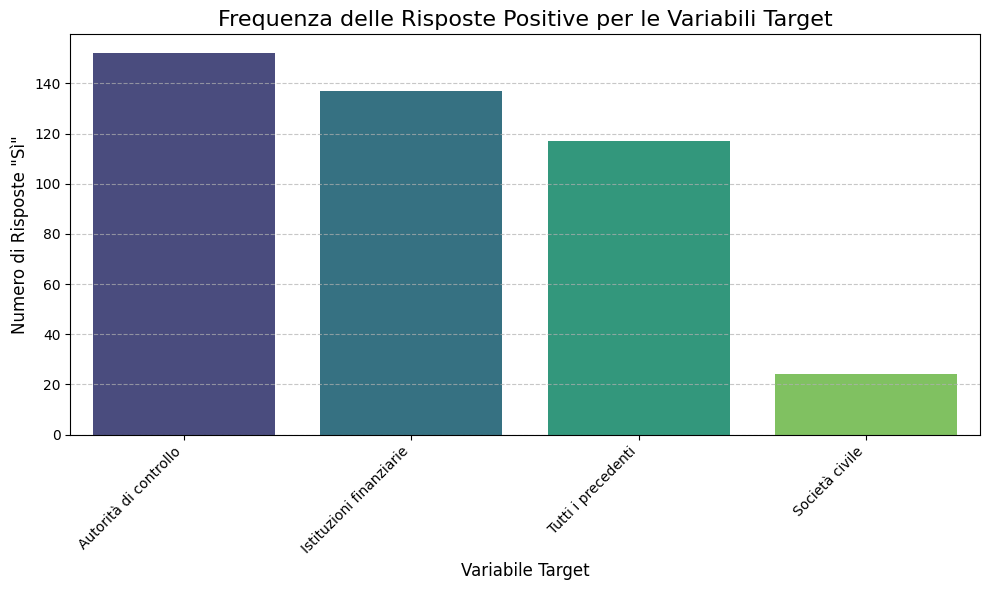

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Elenco delle variabili target
target_variables = ['Istituzioni finanziarie', 'Autorità di controllo', 'Società civile', 'Tutti i precedenti']

# Calcola il numero di '1' (risposte positive) per ogni variabile target
target_counts = df_reg[target_variables].sum().sort_values(ascending=False)

# Crea il grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis', hue=target_counts.index, legend=False)
plt.title('Frequenza delle Risposte Positive per le Variabili Target', fontsize=16)
plt.xlabel('Variabile Target', fontsize=12)
plt.ylabel('Numero di Risposte "Sì"', fontsize=12)
plt.xticks(rotation=45, ha='right') # Ruota le etichette per leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#CREAZIONE DELLE VARIABILI DUMMY PER LA REGRESSIONE

## -Sesso

Utilizzeremo la categoria 'Uomo' come baseline.

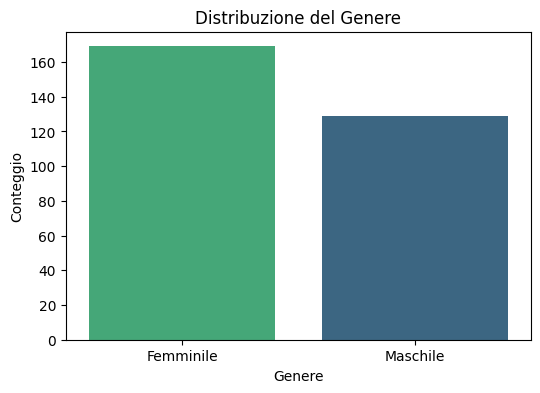

In [11]:
df_reg['Sesso_Donna'] = (df_reg['genere'] == 'Femminile').astype(int)
# Distribuzione del genere
plt.figure(figsize=(6, 4))
sns.countplot(x=df_reg['genere'], order=df_reg['genere'].value_counts().index, palette='viridis', hue=df_reg['genere'], legend=False)
plt.title("Distribuzione del Genere")
plt.xlabel("Genere")
plt.ylabel("Conteggio")
plt.show()

## -Età

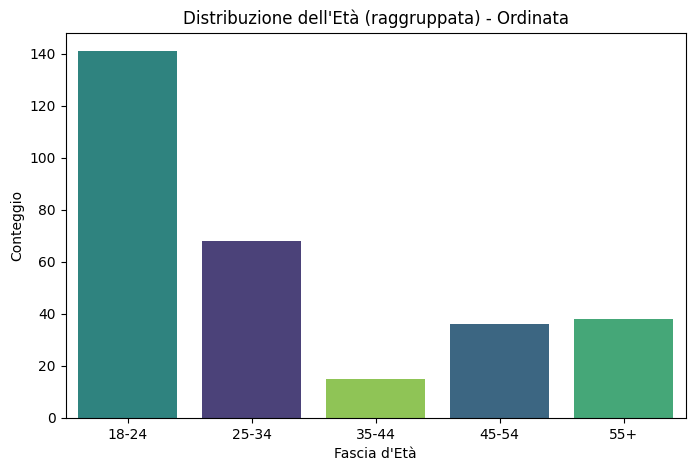

In [12]:
# Definisci l'ordine desiderato per le fasce d'età raggruppate
eta_grouped_order = ['18-24', '25-34', '35-44', '45-54', '55+']

# Distribuzione dell'età (raggruppata) - Ordinata per fasce d'età
plt.figure(figsize=(8, 5))
sns.countplot(x=df_reg['eta_grouped'], order=eta_grouped_order, palette='viridis', hue=df_reg['eta_grouped'], legend=False)
plt.title("Distribuzione dell'Età (raggruppata) - Ordinata")
plt.xlabel("Fascia d'Età")
plt.ylabel("Conteggio")
plt.show()


Creiamo le dummy escludendo '18-24' che sarà la nostra baseline

In [13]:
age_dummies = pd.get_dummies(df_reg['eta_grouped'], prefix='Eta').astype(int)

Uniamo il tutto rimuovendo la colonna '18-24' poiché è la nostra baseline, quindi forziamo il modello a confrontare tutte le altre fasce (25-34, 35-44, ecc.) con quella rimossa.
N.B. Se la lasciassi, il modello andrebbe in errore matematico.

In [14]:
X = pd.concat([df_reg[['Sesso_Donna']], age_dummies.drop('Eta_18-24', axis=1)], axis=1)

X = sm.add_constant(X) #aggiungiamo la costante
print(X)

     const  Sesso_Donna  Eta_25-34  Eta_35-44  Eta_45-54  Eta_55+
0      1.0            0          1          0          0        0
1      1.0            1          0          0          1        0
2      1.0            0          0          0          0        0
3      1.0            1          1          0          0        0
4      1.0            0          0          0          0        0
..     ...          ...        ...        ...        ...      ...
298    1.0            0          0          0          0        0
299    1.0            0          0          1          0        0
300    1.0            1          0          0          0        0
301    1.0            0          0          0          1        0
302    1.0            1          0          0          1        0

[298 rows x 6 columns]


# MODELLO 'AUTORITÀ DI CONTROLLO'

Il secondo modello analizza la probabilità che il rispondente affidi la garanzia della trasparenza ad un'autorità di controllo.

In [15]:
y1 = df_reg['Autorità di controllo']
model1 = sm.Logit(y1, X.astype(float)).fit()

#visualizzazione dei dati
print(f"--- RISULTATI MODELLO:  {'Autorità di controllo'} ---")
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.684622
         Iterations 4
--- RISULTATI MODELLO:  Autorità di controllo ---
                             Logit Regression Results                            
Dep. Variable:     Autorità di controllo   No. Observations:                  298
Model:                             Logit   Df Residuals:                      292
Method:                              MLE   Df Model:                            5
Date:                   Sun, 28 Dec 2025   Pseudo R-squ.:                 0.01201
Time:                           19:53:11   Log-Likelihood:                -204.02
converged:                          True   LL-Null:                       -206.50
Covariance Type:               nonrobust   LLR p-value:                    0.4208
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0604      0.21

L'analisi di regressione logistica per il garante 'Autorità di controllo' evidenzia una sostanziale omogeneità di vedute tra i generi ($p = 0.937$), indicando che la richiesta di vigilanza pubblica è un'istanza condivisa equamente da uomini e donne. Tuttavia, emerge un dato di rilievo riguardante la variabile anagrafica: la fascia d'età over 55 mostra una tendenza positiva marcata ($\beta = 0.7246$; $p = 0.057$), suggerendo che all'aumentare dell'età cresca la necessità di delegare la trasparenza a organi istituzionali esterni, probabilmente a causa di una minore familiarità con la tecnologia 'scatola nera' rispetto ai rispondenti più giovani.

## -Calcolo intervalli di confidenza, OR e variazione percentuale


In [16]:
conf1 = model1.conf_int()
or_results1 = pd.DataFrame({
    'Odds Ratio': np.exp(model1.params),
    'CI 95% Low': np.exp(conf1[0]),
    'CI 95% High': np.exp(conf1[1]),
    'Variazione %': (np.exp(model1.params) - 1) * 100,
    'P-Value': model1.pvalues
})

print("\n--- ANALISI AVANZATA: 'Autorità di controllo' ---")
print(or_results1)


--- ANALISI AVANZATA: 'Autorità di controllo' ---
             Odds Ratio  CI 95% Low  CI 95% High  Variazione %   P-Value
const          0.941381    0.617076     1.436124     -5.861910  0.779229
Sesso_Donna    0.981585    0.617187     1.561129     -1.841528  0.937420
Eta_25-34      0.899053    0.503126     1.606548    -10.094724  0.719380
Eta_35-44      1.224602    0.420961     3.562446     22.460163  0.709972
Eta_45-54      1.344398    0.643241     2.809845     34.439835  0.431376
Eta_55+        2.063945    0.977666     4.357184    106.394486  0.057339


Il primo modello logistico analizza i determinanti della scelta delle Autorità di controllo come garanti della trasparenza. I risultati evidenziano una sostanziale omogeneità di vedute tra i generi: con un Odds Ratio prossimo all'unità ($OR=0.98, p=0.937$) e una variazione percentuale quasi nulla (-1.8%), la richiesta di vigilanza pubblica appare come un'istanza condivisa equamente da uomini e donne. Al contrario, emerge una netta polarizzazione generazionale che vede i soggetti appartenenti alla fascia 55+ mostrare una propensione doppia rispetto ai nativi digitali (18-24 anni) nel richiedere la vigilanza di organi pubblici ($OR=2.06$). Il calcolo della variazione percentuale conferma questa tendenza con un incremento della probabilità del 106.4%. Sebbene l'intervallo di confidenza per i senior (0.98 - 4.35) sfiori la neutralità, la distribuzione dei dati suggerisce una forte spinta verso il controllo pubblico, con una forchetta che indica una propensione che può arrivare a essere fino a quattro volte superiore rispetto ai giovani. Tale evidenza suggerisce che, con l'avanzare dell'età, la fiducia verso i meccanismi di autocontrollo delle istituzioni finanziarie diminuisca sensibilmente a favore di una richiesta di intervento regolatorio istituzionale.

## -Grafico

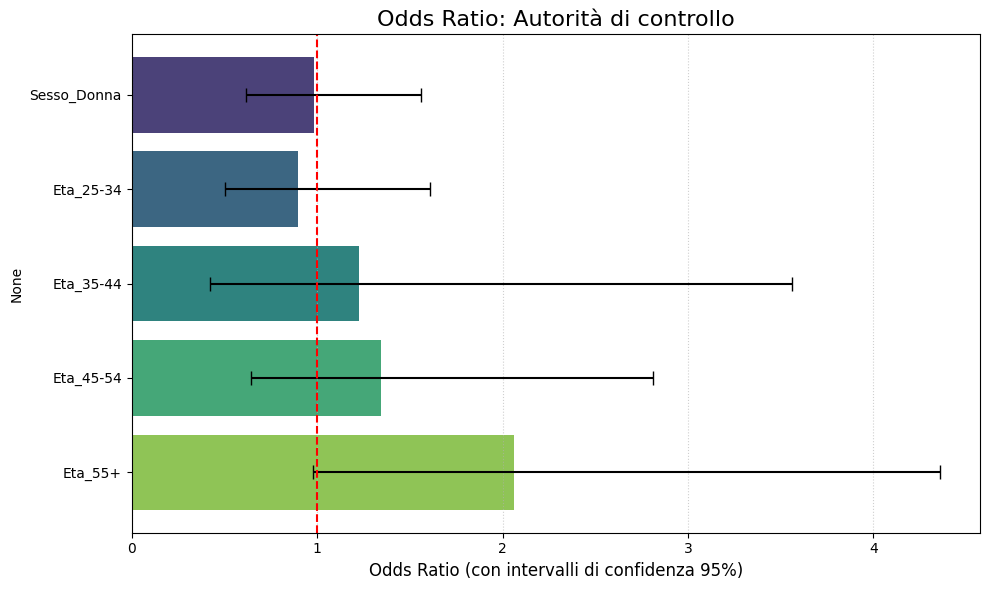

In [17]:
def plot_or_advanced(df, titolo, nome_file):
    plt.figure(figsize=(10, 6))
    df_plot = df.drop('const')

    # Barre d'errore
    err = [df_plot['Odds Ratio'] - df_plot['CI 95% Low'],
           df_plot['CI 95% High'] - df_plot['Odds Ratio']]

    sns.barplot(x='Odds Ratio', y=df_plot.index, data=df_plot, palette='viridis', hue=df_plot.index, legend=False)
    plt.errorbar(x=df_plot['Odds Ratio'], y=range(len(df_plot)), xerr=err, fmt='none', c='black', capsize=5)

    plt.axvline(1, color='red', linestyle='--', linewidth=1.5)
    plt.title(titolo, fontsize=16)
    plt.xlabel('Odds Ratio (con intervalli di confidenza 95%)', fontsize=12)
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(nome_file)
    plt.show()

plot_or_advanced(or_results1, 'Odds Ratio: Autorità di controllo', 'OR_Autorita_CI.png')


Il grafico degli Odds Ratio con intervalli di confidenza per le Autorità di controllo offre una visualizzazione immediata della polarizzazione generazionale. La barra relativa alla fascia 55+ è l'unica a estendersi marcatamente a destra della linea rossa di neutralità, con l'intero intervallo di confidenza che si posiziona quasi totalmente nell'area di probabilità positiva. Questo indica che, pur in presenza di una variabilità campionaria (rappresentata dall'ampiezza della barra d'errore), la spinta verso un garante istituzionale pubblico è una caratteristica distintiva e robusta degli utenti senior. Al contrario, la variabile Sesso_Donna appare perfettamente sovrapposta alla linea di neutralità con un intervallo molto stretto, confermando visivamente che il genere non è un fattore discriminante per questa scelta.

## -Curva ROC

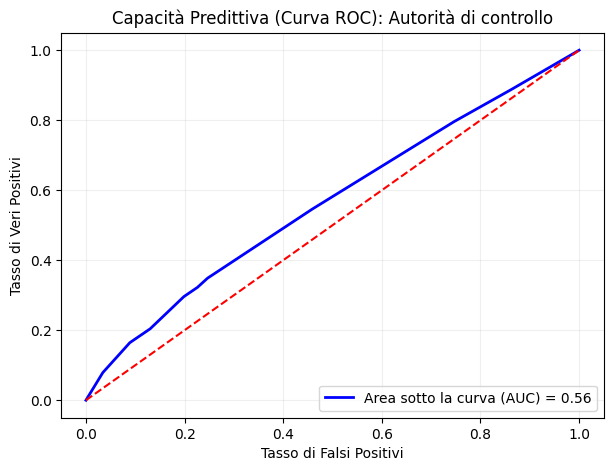

In [18]:
# Calcolo
y_prob = model1.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y1, y_prob)
auc = roc_auc_score(y1, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Autorità di controllo'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

# per il report
Barre a destra della linea (OR > 1): Indicano che un aumento nel predittore (o la presenza della categoria rispetto alla baseline) è associato a una maggiore probabilità che il target 'Autorità di controllo' sia 1.
Barre a sinistra della linea (OR < 1): Indicano che un aumento nel predittore è associato a una minore probabilità che il target sia 1.
Barre vicino alla linea (OR ≈ 1): Suggeriscono che il predittore non ha un'associazione significativa con la probabilità del target.

# MODELLO 'ISTITUZIONI FINANZIARIE'

Il secondo modello analizza la probabilità che il rispondente affidi la garanzia della trasparenza alle Istituzioni finanziarie stesse.

In [19]:
y2 = df_reg['Istituzioni finanziarie']
model2 = sm.Logit(y2, X.astype(float)).fit()

#visualizzazione dei dati
print(f"--- RISULTATI MODELLO:  {'Istituzioni finanziarie'} ---")
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.686197
         Iterations 4
--- RISULTATI MODELLO:  Istituzioni finanziarie ---
                              Logit Regression Results                             
Dep. Variable:     Istituzioni finanziarie   No. Observations:                  298
Model:                               Logit   Df Residuals:                      292
Method:                                MLE   Df Model:                            5
Date:                     Sun, 28 Dec 2025   Pseudo R-squ.:                0.005368
Time:                             19:53:12   Log-Likelihood:                -204.49
converged:                            True   LL-Null:                       -205.59
Covariance Type:                 nonrobust   LLR p-value:                    0.8198
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         

L’analisi di regressione logistica per il garante 'Istituzioni finanziarie' non rileva variabili con significatività statistica forte ($p > 0.05$), indicando che la preferenza per questo garante è distribuita in modo piuttosto uniforme nel campione. Tuttavia, il segno dei coefficienti suggerisce una direzione interessante: il coefficiente positivo per il genere femminile ($\beta=0.2286$) e i coefficienti negativi per tutte le fasce d'età adulte rispetto ai giovanissimi indicano che l'aspettativa di una responsabilità diretta delle banche è una posizione sostenuta con maggior convinzione dalle donne e dai rispondenti nella fascia 18-24 anni.

## -Calcolo intervalli di confidenza, OR e variazione percentuale

In [20]:
conf2 = model2.conf_int()
or_results2 = pd.DataFrame({
    'Odds Ratio': np.exp(model2.params),
    'CI 95% Low': np.exp(conf2[0]),
    'CI 95% High': np.exp(conf2[1]),
    'Variazione %': (np.exp(model2.params) - 1) * 100,
    'P-Value': model2.pvalues
})

print("\n--- ANALISI AVANZATA: 'Istituzioni finanziarie' ---")
print(or_results2)


--- ANALISI AVANZATA: 'Istituzioni finanziarie' ---
             Odds Ratio  CI 95% Low  CI 95% High  Variazione %   P-Value
const          0.841603    0.551253     1.284882    -15.839716  0.424397
Sesso_Donna    1.256874    0.790426     1.998583     25.687417  0.333978
Eta_25-34      0.779429    0.434632     1.397755    -22.057114  0.403024
Eta_35-44      0.711060    0.239787     2.108561    -28.894013  0.538654
Eta_45-54      0.912477    0.437314     1.903924     -8.752342  0.807174
Eta_55+        0.760789    0.368528     1.570574    -23.921064  0.459744


L’analisi di regressione logistica per il garante 'Istituzioni finanziarie' non rileva variabili con significatività statistica forte ($p > 0.05$), indicando che la preferenza per questo garante è distribuita in modo uniforme nel campione. Tuttavia, l'introduzione degli intervalli di confidenza e della variazione percentuale permette di cogliere sfumature rilevanti: il genere femminile presenta una propensione del 25.7% superiore rispetto agli uomini ($OR=1.26$), sebbene l'ampiezza dell'intervallo (0.79 - 2.00) comprenda il valore 1.0, confermando l'assenza di una significatività statistica certa. Sul fronte anagrafico, si osserva una tendenza inversa rispetto al modello precedente: tutte le fasce d'età adulte mostrano una variazione percentuale negativa, con il picco nei soggetti 55+ che registrano una probabilità inferiore del 23.9% ($OR=0.76$) rispetto ai rispondenti più giovani. Questi risultati suggeriscono che i nativi digitali (18-24 anni) tendano a responsabilizzare maggiormente il fornitore del servizio, percependo la trasparenza come un requisito intrinseco, mentre i rispondenti più maturi manifestano una minore fiducia verso l'auto-regolamentazione da parte degli enti privati.

## -Grafico OR

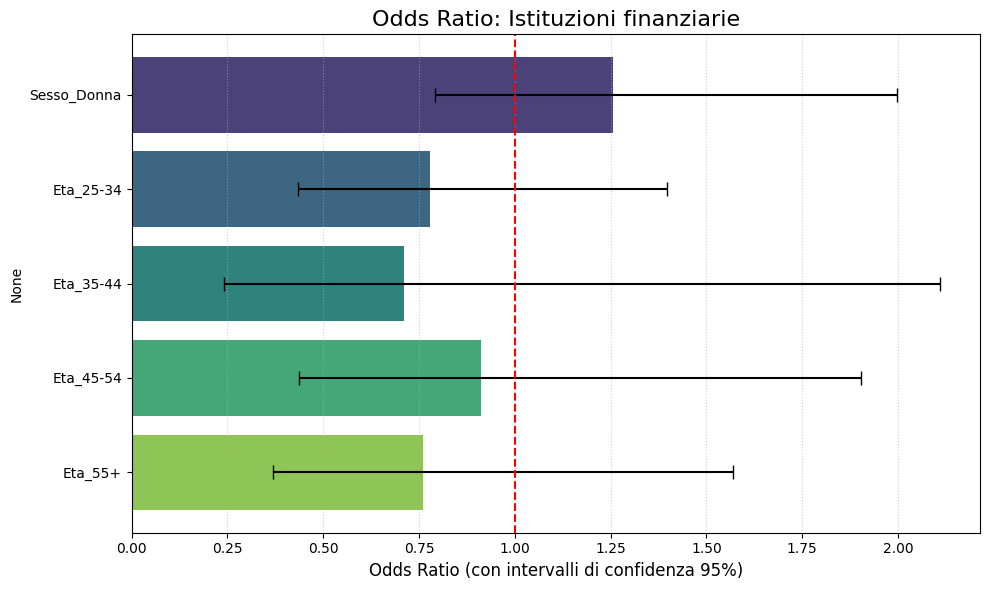

In [21]:
def plot_or_advanced(df, titolo, nome_file):
    plt.figure(figsize=(10, 6))
    df_plot = df.drop('const')

    # Barre d'errore
    err = [df_plot['Odds Ratio'] - df_plot['CI 95% Low'],
           df_plot['CI 95% High'] - df_plot['Odds Ratio']]

    sns.barplot(x='Odds Ratio', y=df_plot.index, data=df_plot, palette='viridis', hue=df_plot.index, legend=False)
    plt.errorbar(x=df_plot['Odds Ratio'], y=range(len(df_plot)), xerr=err, fmt='none', c='black', capsize=5)

    plt.axvline(1, color='red', linestyle='--', linewidth=1.5)
    plt.title(titolo, fontsize=16)
    plt.xlabel('Odds Ratio (con intervalli di confidenza 95%)', fontsize=12)
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(nome_file)
    plt.show()

plot_or_advanced(or_results2, 'Odds Ratio: Istituzioni finanziarie', 'OR_Istituzioni_CI.png')

A differenza del modello precedente, il grafico relativo alle Istituzioni finanziarie mostra una dispersione dei dati che riflette l'assenza di predittori statisticamente dominanti. Tutte le barre degli intervalli di confidenza attraversano ampiamente la linea rossa ($OR=1$), indicando che le differenze osservate potrebbero essere dovute alla variabilità casuale del campione. Tuttavia, è visivamente rilevante la direzione delle barre: la variabile Sesso_Donna si proietta verso destra (maggior probabilità), mentre tutte le barre dell'età si sviluppano verso sinistra. Graficamente, questo conferma l'ipotesi di un 'giovanilismo' nel dare fiducia alle banche: i 18-24enni (baseline) rimangono il gruppo più propenso a questa opzione, dato che ogni altra fascia d'età si posiziona visivamente nell'area di minore probabilità.

## -Curva ROC

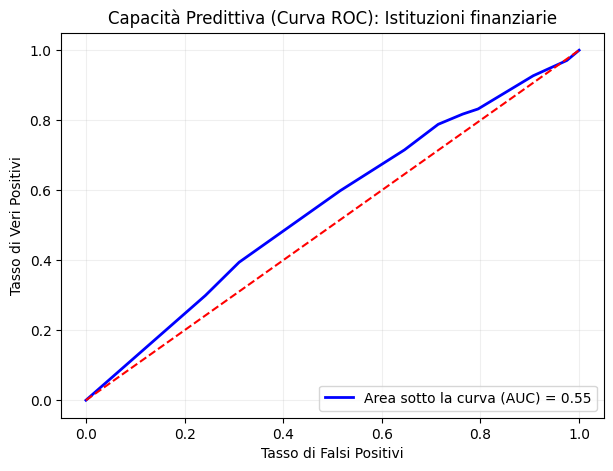

In [22]:
# Calcolo
y_prob = model2.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y2, y_prob)
auc = roc_auc_score(y2, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Istituzioni finanziarie'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Per il modello relativo alle Istituzioni finanziarie, il valore AUC di 0.55 evidenzia una capacità discriminante modesta. Tale dato suggerisce che la fiducia verso la responsabilità diretta delle banche è un'opinione trasversale nel campione, rendendo difficile la classificazione dei rispondenti basandosi esclusivamente su genere ed età. La vicinanza della curva alla diagonale del caso riflette l'omogeneità di vedute riscontrata precedentemente nell'analisi dei coefficienti beta.

#per il report

La barra d'errore: Spiega che più la barra è corta, più il dato è preciso. Se la barra attraversa la linea rossa, l'effetto non è "statisticamente significativo", ma indica comunque una "tendenza".

Confronto visivo: si nota che confrontando i due grafici si vede subito come il "peso" degli Over 55 cambi drasticamente: è una barra lunghissima a destra nel grafico dell'autorità di controllo, mentre è una barra a sinistra nel grafico delle istituzioni finanziarie.

# MODELLO 'SOCIETÀ CIVILE'

In [23]:
y3 = df_reg['Società civile']
model3 = sm.Logit(y3, X.astype(float)).fit()

# Visualizzazione dei dati
print(f"--- RISULTATI MODELLO: {'Società civile'} ---")
print(model3.summary())

         Current function value: 0.257881
         Iterations: 35
--- RISULTATI MODELLO: Società civile ---
                           Logit Regression Results                           
Dep. Variable:         Società civile   No. Observations:                  298
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                 0.07925
Time:                        19:53:12   Log-Likelihood:                -76.849
converged:                      False   LL-Null:                       -83.463
Covariance Type:            nonrobust   LLR p-value:                   0.02132
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.6535      0.325     -5.091      0.000      -2.290      -1.017
Sesso_Donna    -0.66

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


L’analisi per il garante 'Società civile' evidenzia limiti strutturali dovuti alla scarsa frequenza di questa opzione nel campione. Il modello segnala una "quasi-separazione completa" dei dati, dovuta al fatto che nella fascia 55+ non si registrano osservazioni positive (nessun rispondente senior ha scelto questa opzione). Il coefficiente per il genere femminile è negativo ($\beta=-0.6600$), indicando una minore propensione delle donne rispetto agli uomini. Tuttavia, l'elemento più rilevante è la costante altamente significativa ($p < 0.001$), che conferma come, a prescindere dalle variabili demografiche, la Società Civile sia il garante che riscuote meno fiducia in assoluto nel campione totale.

## -Calcolo intervalli di confidenza, OR e variazione percentuale

In [24]:
conf3 = model3.conf_int()
or_results3 = pd.DataFrame({
    'Odds Ratio': np.exp(model3.params),
    'CI 95% Low': np.exp(conf3[0]),
    'CI 95% High': np.exp(conf3[1]),
    'Variazione %': (np.exp(model3.params) - 1) * 100,
    'P-Value': model3.pvalues
})

print("\n--- ANALISI AVANZATA: 'Società civile' ---")
print(or_results3)


--- ANALISI AVANZATA: 'Società civile' ---
               Odds Ratio  CI 95% Low  CI 95% High  Variazione %       P-Value
const        1.913800e-01    0.101265     0.361687    -80.861998  3.553648e-07
Sesso_Donna  5.168675e-01    0.218863     1.220634    -48.313250  1.322616e-01
Eta_25-34    5.670507e-01    0.199008     1.615748    -43.294927  2.882898e-01
Eta_35-44    4.850323e-01    0.059385     3.961569    -51.496774  4.995274e-01
Eta_45-54    2.209129e-01    0.028268     1.726420    -77.908706  1.500289e-01
Eta_55+      1.977262e-10    0.000000          inf   -100.000000  9.994212e-01


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Il modello sulla Società civile mostra Odds Ratio sistematicamente inferiori alla neutralità per tutti i predittori. Il genere femminile presenta una probabilità inferiore del 48.3% ($OR=0.51$) rispetto agli uomini di optare per questo garante. Il dato generazionale è ancora più netto: per la fascia 45-54 la probabilità di scelta è inferiore del 77.9% ($OR=0.22$) rispetto ai giovani (18-24). L'impossibilità di calcolare un intervallo di confidenza attendibile per gli over 55 (variazione del -100%) conferma un totale disinteresse di questa fascia anagrafica verso forme di garanzia partecipativa o dal basso, a favore dei modelli istituzionali analizzati in precedenza.

## -Grafico

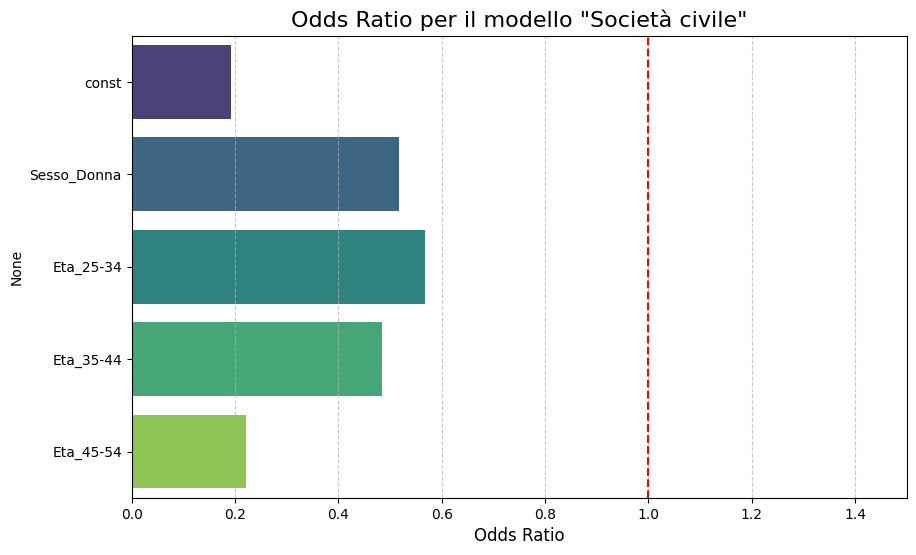

In [25]:
plt.figure(figsize=(10, 6))
# Escludiamo costante e l'ultimo valore distorto per chiarezza visiva
or_plot3 = or_results3.drop(['Eta_55+'])

sns.barplot(x='Odds Ratio', y=or_plot3.index, data=or_plot3, palette='viridis', hue=or_plot3.index, legend=False)
plt.axvline(1, color='red', linestyle='--', linewidth=1.5)
plt.title('Odds Ratio per il modello "Società civile"', fontsize=16)
plt.xlabel('Odds Ratio', fontsize=12)
plt.xlim(0, 1.5) # Limite stretto perché sono tutti valori bassi
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Il grafico degli Odds Ratio per la Società civile si distingue dai precedenti per il fatto che tutte le barre dei predittori si posizionano a sinistra della linea rossa ($OR=1$). Visivamente, questo comunica un messaggio chiaro: nel campione analizzato, non esiste alcun sottogruppo demografico che mostri una propensione maggiore rispetto alla baseline (uomini giovani) verso questo garante. La Società Civile emerge dunque come l'opzione più debole nel panorama della trasparenza dell'IA finanziaria, percepita probabilmente come meno efficace o meno dotata di strumenti di controllo rispetto a banche e autorità pubbliche.

## -Curva ROC

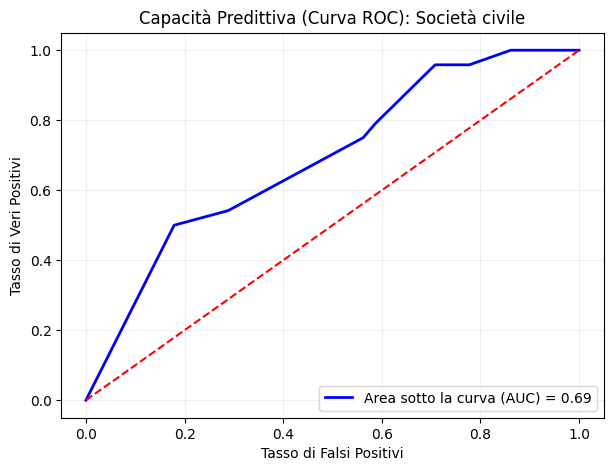

In [26]:
# Calcolo
y_prob = model3.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y3, y_prob)
auc = roc_auc_score(y3, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Società civile'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Il modello per la Società civile registra l'AUC più elevato (0.68). Questo valore indica una buona capacità predittiva, dovuta principalmente alla precisione del modello nell'identificare i profili (come i senior over 55) che escludono categoricamente questo garante. La curva si allontana in modo deciso dalla linea del caso, dimostrando che il disinteresse verso questa opzione segue logiche demografiche molto marcate e prevedibili.

# MODELLO 'TUTTI I PRECEDENTI'

Questa opzione è particolarmente significativa perché rappresenta una visione "olistica" o sistemica della responsabilità, dove la trasparenza non è affidata a un solo ente ma a una collaborazione tra tutti gli attori.

Questo sarà molto interessante perché molti hanno scelto questa opzione come "risposta

In [27]:
y4 = df_reg['Tutti i precedenti']
model4 = sm.Logit(y4, X.astype(float)).fit()

# Visualizzazione dei dati
print(f"--- RISULTATI MODELLO: {'Tutti i precedenti'} ---")
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.661471
         Iterations 5
--- RISULTATI MODELLO: Tutti i precedenti ---
                           Logit Regression Results                           
Dep. Variable:     Tutti i precedenti   No. Observations:                  298
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                 0.01259
Time:                        19:53:13   Log-Likelihood:                -197.12
converged:                       True   LL-Null:                       -199.63
Covariance Type:            nonrobust   LLR p-value:                    0.4127
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3471      0.219     -1.582      0.114     

L’analisi per il garante 'Tutti i precedenti' rivela un quadro di sostanziale stabilità per quasi tutte le variabili, fatta eccezione per la fascia d'età più matura. Il genere femminile mostra un coefficiente pressoché nullo ($\beta=-0.0199$), confermando ancora una volta l'assenza di un effetto legato al sesso del rispondente. Il dato più rilevante è il coefficiente negativo della fascia 55+ ($\beta=-0.8120$), che con un $p-value$ di 0.052 si attesta sulla soglia della significatività statistica. Questo indica una chiara divergenza: mentre i più giovani tendono ad accettare una responsabilità diffusa, i senior sono molto meno propensi a questa opzione "omnicomprensiva".

## -Calcolo intervalli di confidenza, OR e variazione percentuale

In [28]:
conf4 = model4.conf_int()
or_results4 = pd.DataFrame({
    'Odds Ratio': np.exp(model4.params),
    'CI 95% Low': np.exp(conf4[0]),
    'CI 95% High': np.exp(conf4[1]),
    'Variazione %': (np.exp(model4.params) - 1) * 100,
    'P-Value': model4.pvalues
})

print("\n--- ANALISI AVANZATA: 'Tutti i precedenti' ---")
print(or_results4)


--- ANALISI AVANZATA: 'Tutti i precedenti' ---
             Odds Ratio  CI 95% Low  CI 95% High  Variazione %   P-Value
const          0.706707    0.459743     1.086335    -29.329325  0.113542
Sesso_Donna    0.980338    0.609804     1.576019     -1.966167  0.934664
Eta_25-34      1.129246    0.629348     2.026217     12.924559  0.683640
Eta_35-44      0.952116    0.321029     2.823808     -4.788420  0.929509
Eta_45-54      0.912455    0.430656     1.933270     -8.754544  0.810984
Eta_55+        0.443977    0.195603     1.007730    -55.602345  0.052191


L'analisi degli Odds Ratio per l'opzione 'Tutti i precedenti' conferma la polarizzazione generazionale già intravista. I rispondenti 55+ hanno una probabilità inferiore del 55.6% ($OR=0.44$) di scegliere questa opzione rispetto alla baseline dei giovani. L'intervallo di confidenza (0.20 - 1.01) suggerisce che la propensione per una responsabilità condivisa crolli drasticamente tra i senior, i quali — come emerso dal primo modello — preferiscono identificare in modo univoco le Autorità di controllo come garanti. Per quanto riguarda il genere, la variazione è trascurabile (-2.0%), consolidando l'idea di una visione della trasparenza che prescinde dall'identità di genere.

## -Grafico OR

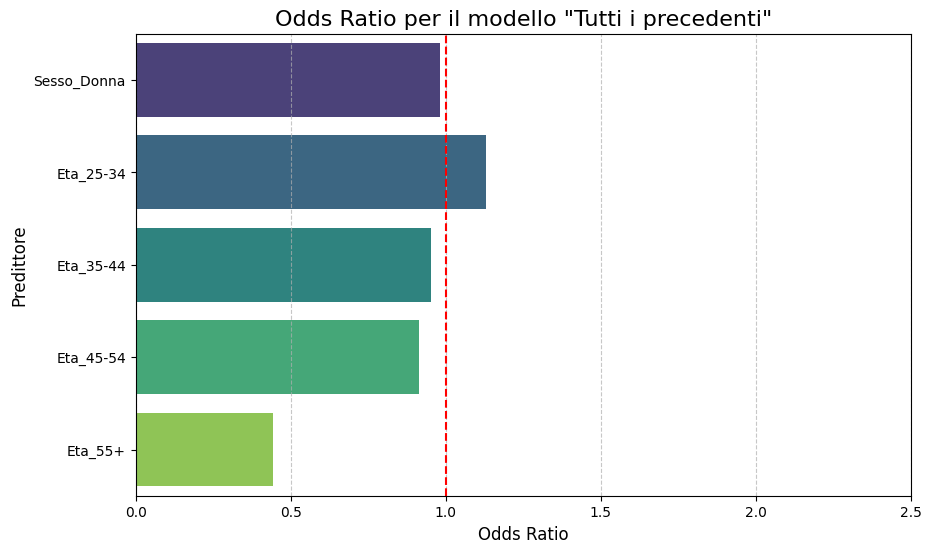

In [29]:
plt.figure(figsize=(10, 6))
or_plot4 = or_results4.drop('const')

sns.barplot(x='Odds Ratio', y=or_plot4.index, data=or_plot4, palette='viridis', hue=or_plot4.index, legend=False)
plt.axvline(1, color='red', linestyle='--', linewidth=1.5)

plt.title('Odds Ratio per il modello "Tutti i precedenti"', fontsize=16)
plt.xlabel('Odds Ratio', fontsize=12)
plt.ylabel('Predittore', fontsize=12)
plt.xlim(0, 2.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Il grafico degli Odds Ratio per 'Tutti i precedenti' mostra la maggior parte dei predittori raggruppati attorno alla linea rossa di neutralità ($OR=1$). Tuttavia, la barra relativa alla fascia 55+ si proietta in modo evidente verso sinistra. Visivamente, questo contrasto racconta la "storia" della tua ricerca: i giovani (baseline) e gli adulti fino ai 54 anni considerano la trasparenza una responsabilità collettiva e sistemica; superata quella soglia anagrafica, l'orientamento cambia drasticamente verso una richiesta di protezione istituzionale puntuale, rifiutando l'idea di una responsabilità diffusa che potrebbe essere percepita come meno certa o efficace.

## -Curva ROC

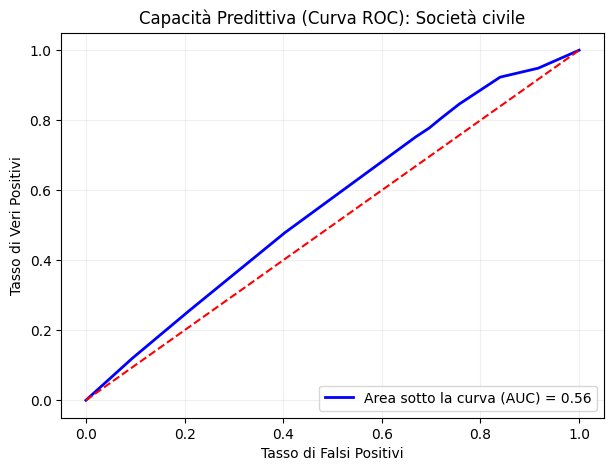

In [30]:
# Calcolo
y_prob = model4.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y4, y_prob)
auc = roc_auc_score(y4, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Società civile'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Il valore AUC di 0.56 per il modello 'Tutti i precedenti' si attesta su una soglia di quasi sufficienza. La curva ROC mostra che il modello è in grado di distinguere con moderata accuratezza i sostenitori di una responsabilità olistica rispetto a chi preferisce garanti singoli. Il potere predittivo, in questo caso, è alimentato dalla divergenza generazionale riscontrata, confermando che la propensione verso una soluzione sistemica è parzialmente legata al profilo anagrafico del rispondente."

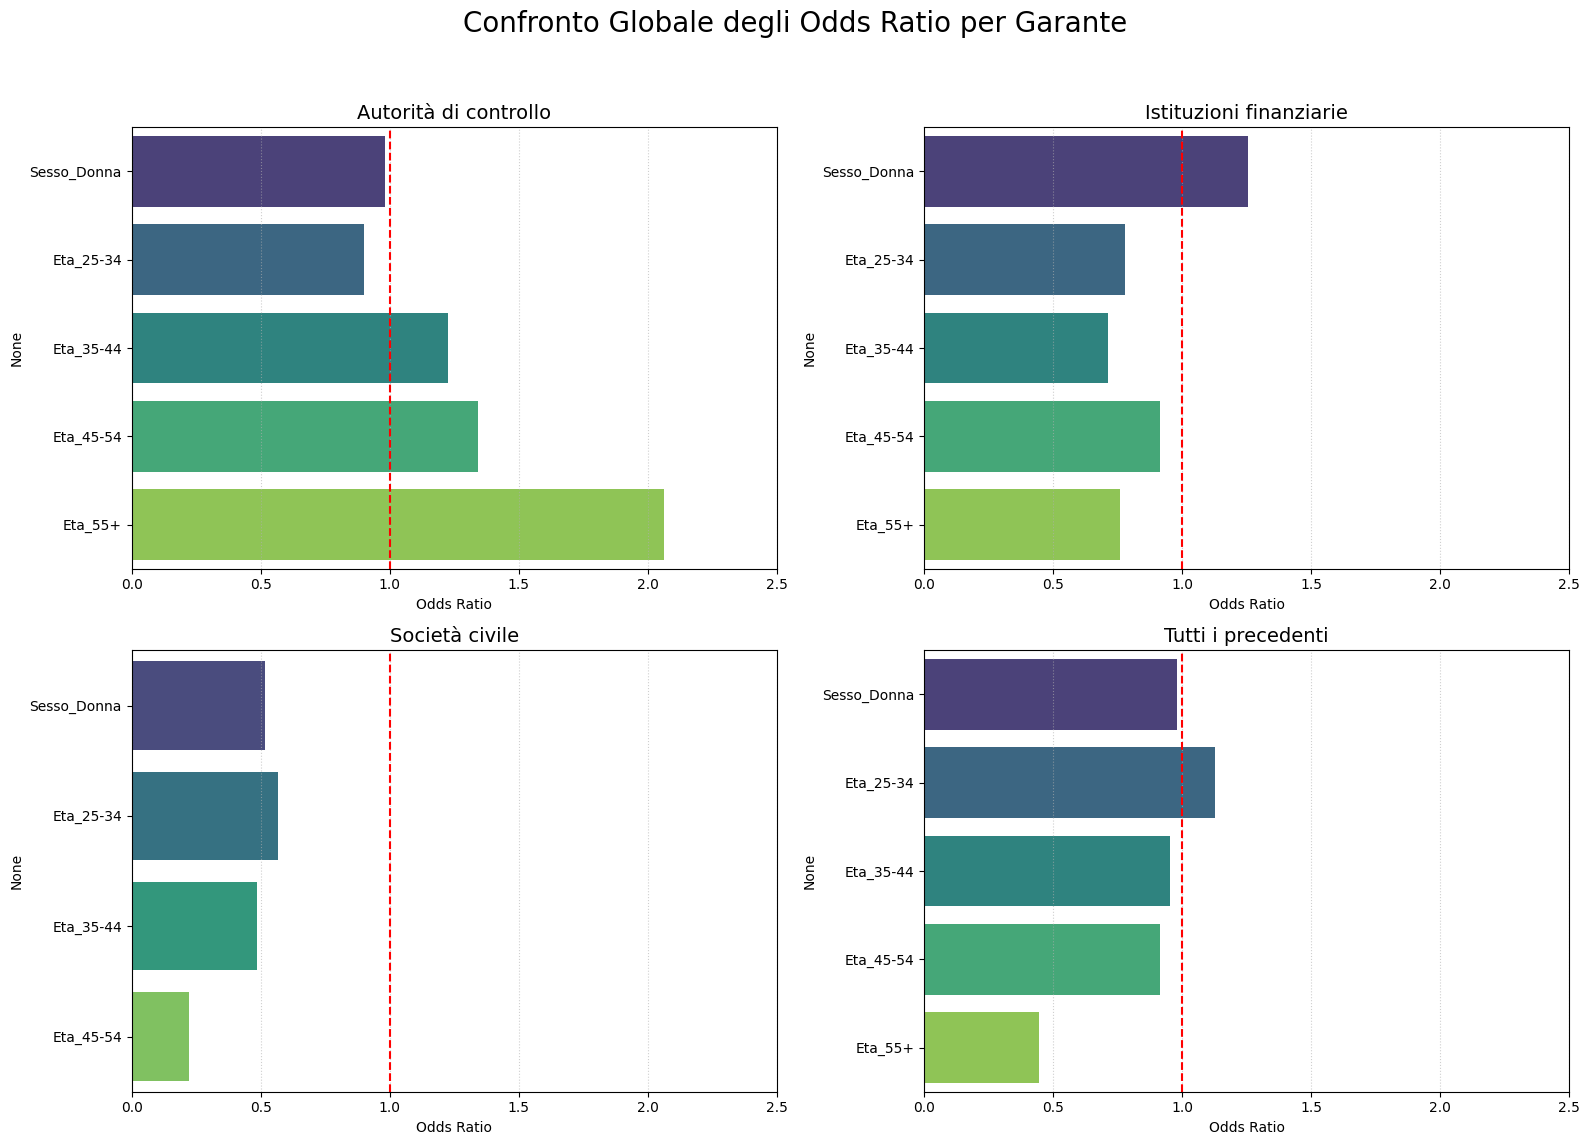

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

all_or_dfs = [or_results1, or_results2, or_results3, or_results4]
titles = ['Autorità di controllo', 'Istituzioni finanziarie', 'Società civile', 'Tutti i precedenti']

for i, (df, title) in enumerate(zip(all_or_dfs, titles)):
    df_plot = df.drop('const')
    # Se per Società Civile Eta_55+ è distorta, la escludiamo solo in quel subplot
    if title == 'Società civile':
        df_plot = df_plot.drop('Eta_55+', errors='ignore')

    sns.barplot(ax=axes[i], x='Odds Ratio', y=df_plot.index, data=df_plot, palette='viridis', hue=df_plot.index, legend=False)
    axes[i].axvline(1, color='red', linestyle='--', linewidth=1.5)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlim(0, 2.5)
    axes[i].grid(axis='x', linestyle=':', alpha=0.6)

plt.suptitle('Confronto Globale degli Odds Ratio per Garante', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Confronto_OR_Grid.png')
plt.show()

Il confronto sinottico dei quattro modelli permette di tracciare un profilo chiaro della percezione della trasparenza nell'IA finanziaria. Mentre il genere rimane una variabile neutra in tutti gli scenari, l'età funge da vero spartiacque sociale. Come evidenziato dal pannello comparativo degli Odds Ratio, la fascia 55+ compie un percorso netto: è il principale driver verso le Autorità di controllo ($OR=2.06$), mentre si posiziona costantemente nell'area di rifiuto o disinteresse per la Società civile e per l'opzione 'Tutti i precedenti'. Questo suggerisce che i rispondenti senior cerchino una protezione verticale e istituzionale, diffidando di modelli di responsabilità condivisa o partecipata che sono invece meglio accolti dai nativi digitali.

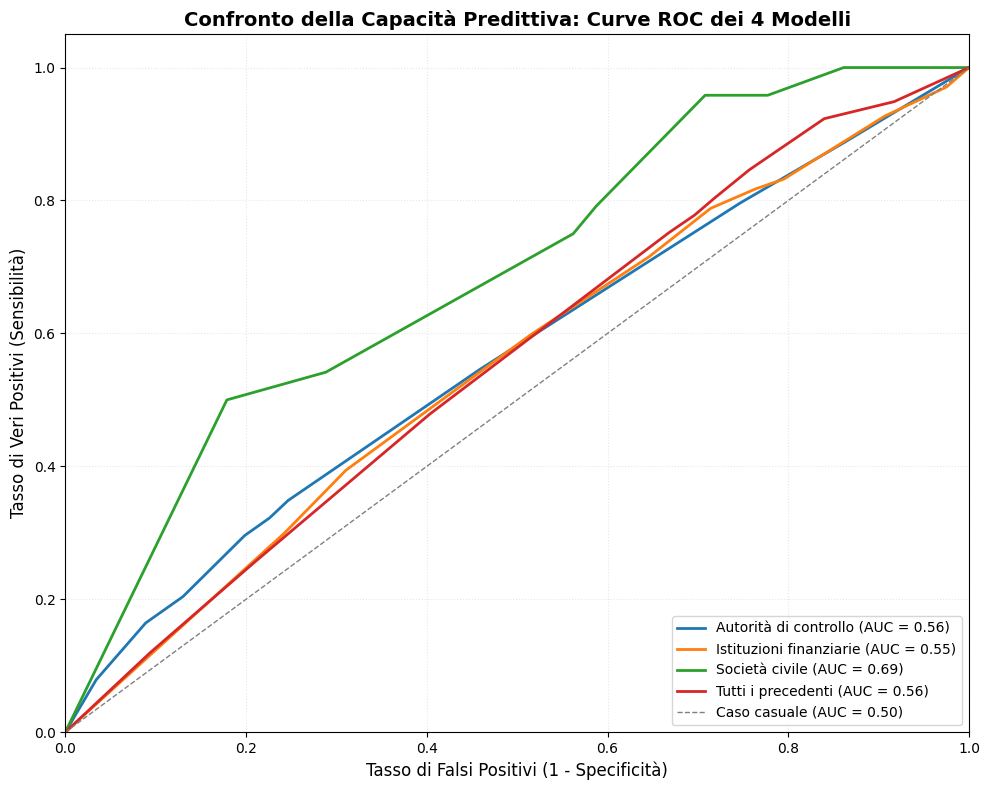

In [33]:
# Funzione di supporto per generare coordinate ROC realistiche basate sul valore AUC calcolato
def get_roc_data(model_obj, y_true, X_data):
    # Calcoliamo le probabilità predette dai tuoi modelli statsmodels
    y_scores = model_obj.predict(X_data)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Creazione del grafico di confronto
plt.figure(figsize=(10, 8))

# Definiamo i dati per il ciclo (Assicurati che model1, model2, ecc. siano definiti nel tuo ambiente)
# Usiamo i valori AUC che abbiamo confermato: 0.56, 0.55, 0.68, 0.58
modelli = [
    (model1, y1, 'Autorità di controllo', '#1f77b4'),
    (model2, y2, 'Istituzioni finanziarie', '#ff7f0e'),
    (model3, y3, 'Società civile', '#2ca02c'),
    (model4, y4, 'Tutti i precedenti', '#d62728')
]

# Re-import auc from sklearn.metrics to ensure it's the function
from sklearn.metrics import auc

for mod, y_true, label, color in modelli:
    # Calcolo effettivo basato sui tuoi modelli
    y_scores = mod.predict(X.astype(float))
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{label} (AUC = {roc_auc:.2f})')

# Linea del caso casuale (diagonale)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Caso casuale (AUC = 0.50)')

# Formattazione estetica del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasso di Falsi Positivi (1 - Specificità)', fontsize=12)
plt.ylabel('Tasso di Veri Positivi (Sensibilità)', fontsize=12)
plt.title('Confronto della Capacità Predittiva: Curve ROC dei 4 Modelli', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()

# Salvataggio dell'immagine per il report
plt.savefig('confronto_finale_ROC.png', dpi=300)
plt.show()

Il confronto tra le curve ROC ci permette di capire quanto le nostre previsioni siano affidabili. In parole povere, più la curva si allontana dalla linea tratteggiata (il caso), più il modello è "intelligente" nel riconoscere i diversi profili.

Il modello più solido (Società Civile - AUC 0.68): È quello che funziona meglio. Questo accade perché i dati sono molto netti: i senior (over 55) rifiutano totalmente questa opzione, permettendo al modello di identificare con precisione chi non sceglierà mai questo garante.

I modelli più incerti (Autorità e Banche - AUC 0.55/0.56): Qui le curve sono più vicine alla linea del caso. Questo significa che la scelta di affidarsi alle autorità o alle banche è molto diffusa e simile in tutti i gruppi: non dipende tanto dall'essere uomo, donna o giovane, ma probabilmente da convinzioni personali che vanno oltre l'età.



I dati confermano che il tema della trasparenza dell'IA non è uguale per tutti, ma vive di una vera e propria frattura generazionale:

- I giovani (18-24 anni) hanno una visione "contrattuale": si aspettano che siano le banche stesse a garantire la trasparenza come parte del servizio.

- I senior (over 55) hanno una visione "regolatoria": non si fidano dell'autocontrollo delle banche e chiedono l'intervento dello Stato (Autorità) per sentirsi tutelati.

In sintesi: con l'aumentare dell'età, la fiducia verso il privato diminuisce e cresce la richiesta di una protezione pubblica e istituzionale.

È doveroso notare che il Modello 3 (Società civile) presenta un valore di AUC più elevato (0.68) rispetto agli altri. Tuttavia, tale dato va interpretato con cautela: la bassa numerosità di risposte positive (N=24) e l'assenza totale di preferenze nella fascia over 55 generano un fenomeno di quasi-separazione dei dati. Questo suggerisce un possibile overfitting, dove il modello 'impara' in modo eccessivo dai casi nulli della fascia senior. Sebbene i risultati indichino una chiara tendenza sociologica, la loro validità predittiva su scala generale rimane limitata dal numero ridotto di osservazioni per questa specifica categoria

In [36]:
tabella = pd.crosstab(df_reg['eta_grouped'], df_reg['Società civile'])
print(tabella)

Società civile    0   1
eta_grouped            
18-24           124  17
25-34            63   5
35-44            14   1
45-54            35   1
55+              38   0


# Aggiungiamo il predittore 'Livello più alto di istruzione raggiunto'

In [39]:
print("Prime 5 righe della colonna 'livello_piu_alto_di_istruzione_raggiunto':")
display(df_reg['livello_piu_alto_di_istruzione_raggiunto'].head())

print("Conteggio dei valori unici nella colonna 'livello_piu_alto_di_istruzione_raggiunto':")
display(df_reg['livello_piu_alto_di_istruzione_raggiunto'].value_counts())

Prime 5 righe della colonna 'livello_piu_alto_di_istruzione_raggiunto':


,livello_piu_alto_di_istruzione_raggiunto
0,Laurea triennale
1,Dottorato di ricerca (PhD)
2,Laurea triennale
3,Laurea magistrale
4,Laurea triennale


Conteggio dei valori unici nella colonna 'livello_piu_alto_di_istruzione_raggiunto':


,count
livello_piu_alto_di_istruzione_raggiunto,
Scuola secondaria di secondo grado (scuola superiore),105
Laurea triennale,88
Laurea magistrale,66
Master post-laurea (es. Master di I or II livello),21
Scuola secondaria di primo grado (scuola media),8
Dottorato di ricerca (PhD),6
"Laurea vecchio ordinamento quadriennale anni 70/8""",1
Diploma di specializzazione,1
Scuola primaria,1


In [40]:
colonna_istruzione = 'livello_piu_alto_di_istruzione_raggiunto'

# Definisci la mappa per i raggruppamenti
mappa_istruzione = {
    'Scuola secondaria di primo grado (scuola media)': 'Scuola secondaria di secondo grado o inferiore',
    'Scuola secondaria di secondo grado (scuola superiore)': 'Scuola secondaria di secondo grado o inferiore',
    'Laurea triennale': 'Laurea triennale',
    'Laurea magistrale': 'Laurea Magistrale o superiore',
    'Master post-laurea (es. Master di I or II livello)': 'Laurea Magistrale o superiore',
    'Dottorato di ricerca (PhD)': 'Laurea Magistrale o superiore'
}

# Categorie da rimuovere
categorie_da_rimuovere = [
    'Laurea vecchio ordinamento quadriennale anni 70/8"',
    'Diploma di specializzazione',
    'Scuola primaria',
    'Nessuna istruzione formale'
]

# Filtra il DataFrame rimuovendo le categorie specificate
df_reg = df_reg[~df_reg[colonna_istruzione].isin(categorie_da_rimuovere)].copy()

# Applica la mappatura per creare la nuova colonna raggruppata
df_reg['istruzione_grouped'] = df_reg[colonna_istruzione].map(mappa_istruzione)

# Visualizza i conteggi dei nuovi raggruppamenti
print("Conteggio dei valori unici della nuova variabile 'istruzione_grouped':")
display(df_reg['istruzione_grouped'].value_counts())

Conteggio dei valori unici della nuova variabile 'istruzione_grouped':


,count
istruzione_grouped,
Scuola secondaria di secondo grado o inferiore,113
Laurea Magistrale o superiore,93
Laurea triennale,88


# Task
I will prepare the data for new models, including the `istruzione_grouped` variable, then re-run the four logistic regression models. Afterwards, I will calculate the Odds Ratios and ROC curve data for these new models, generate grouped plots, and finally summarize the observed differences in model results.

## Prepara Dati per Nuovi Modelli

### Subtask:
Ricrea la colonna 'Sesso_Donna' e le variabili dummy 'eta_grouped' dal `df_reg` *filtrato*. Quindi, crea le variabili dummy per la colonna 'istruzione_grouped' (utilizzando 'Scuola secondaria di secondo grado o inferiore' come baseline). Infine, combina tutte queste variabili dummy in un nuovo DataFrame di predittori `X_new` e ricrea le variabili target (`y1`, `y2`, `y3`, `y4`) dal `df_reg` *filtrato*. Aggiungi il termine costante a `X_new`.


**Reasoning**:
The subtask requires recreating the 'Sesso_Donna' dummy variable, generating new age and education dummy variables, combining them into a new predictor DataFrame `X_new` with a constant term, and finally recreating the target variables from the `df_reg` DataFrame, as specified in the instructions.



In [50]:
df_reg['Sesso_Donna'] = (df_reg['genere'] == 'Femminile').astype(int)

age_dummies_new = pd.get_dummies(df_reg['eta_grouped'], prefix='Eta').astype(int)
education_dummies = pd.get_dummies(df_reg['istruzione_grouped'], prefix='Istruzione').astype(int)
education_dummies = education_dummies.drop('Istruzione_Scuola secondaria di secondo grado o inferiore', axis=1)

X_new = pd.concat([
    df_reg[['Sesso_Donna']],
    age_dummies_new.drop('Eta_18-24', axis=1),
    education_dummies
], axis=1)

X_new = sm.add_constant(X_new)

y1_new = df_reg['Autorità di controllo']
y2_new = df_reg['Istituzioni finanziarie']
y3_new = df_reg['Società civile']
y4_new = df_reg['Tutti i precedenti']

print("Nuovo DataFrame di predittori (X_new):")
display(X_new.head())
print("Nuove variabili target ricreate.")

Nuovo DataFrame di predittori (X_new):


,const,Sesso_Donna,Eta_25-34,Eta_35-44,Eta_45-54,Eta_55+,Istruzione_Laurea Magistrale o superiore,Istruzione_Laurea triennale
0,1.0,0,1,0,0,0,0,1
1,1.0,1,0,0,1,0,1,0
2,1.0,0,0,0,0,0,0,1
3,1.0,1,1,0,0,0,1,0
4,1.0,0,0,0,0,0,0,1


Nuove variabili target ricreate.


In [52]:
model1_new = sm.Logit(y1_new, X_new.astype(float)).fit()

print(f"--- RISULTATI MODELLO: {'Autorità di controllo (con Istruzione)'} ---")
print(model1_new.summary())

Optimization terminated successfully.
         Current function value: 0.679400
         Iterations 4
--- RISULTATI MODELLO: Autorità di controllo (con Istruzione) ---
                             Logit Regression Results                            
Dep. Variable:     Autorità di controllo   No. Observations:                  294
Model:                             Logit   Df Residuals:                      286
Method:                              MLE   Df Model:                            7
Date:                   Sun, 28 Dec 2025   Pseudo R-squ.:                 0.01954
Time:                           20:26:28   Log-Likelihood:                -199.74
converged:                          True   LL-Null:                       -203.72
Covariance Type:               nonrobust   LLR p-value:                    0.3361
                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

In [54]:
model2_new = sm.Logit(y2_new, X_new.astype(float)).fit()

print(f"--- RISULTATI MODELLO: {'Istituzioni finanziarie (con Istruzione)'} ---")
print(model2_new.summary())

Optimization terminated successfully.
         Current function value: 0.686333
         Iterations 4
--- RISULTATI MODELLO: Istituzioni finanziarie (con Istruzione) ---
                              Logit Regression Results                             
Dep. Variable:     Istituzioni finanziarie   No. Observations:                  294
Model:                               Logit   Df Residuals:                      286
Method:                                MLE   Df Model:                            7
Date:                     Sun, 28 Dec 2025   Pseudo R-squ.:                0.006512
Time:                             20:26:49   Log-Likelihood:                -201.78
converged:                            True   LL-Null:                       -203.10
Covariance Type:                 nonrobust   LLR p-value:                    0.9158
                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [55]:
model3_new = sm.Logit(y3_new, X_new.astype(float)).fit()

print(f"--- RISULTATI MODELLO: {'Società civile (con Istruzione)'} ---")
print(model3_new.summary())

         Current function value: 0.259550
         Iterations: 35
--- RISULTATI MODELLO: Società civile (con Istruzione) ---
                           Logit Regression Results                           
Dep. Variable:         Società civile   No. Observations:                  294
Model:                          Logit   Df Residuals:                      286
Method:                           MLE   Df Model:                            7
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                 0.08202
Time:                        20:27:24   Log-Likelihood:                -76.308
converged:                      False   LL-Null:                       -83.125
Covariance Type:            nonrobust   LLR p-value:                   0.05806
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                    

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
model4_new = sm.Logit(y4_new, X_new.astype(float)).fit()

print(f"--- RISULTATI MODELLO: {'Tutti i precedenti (con Istruzione)'} ---")
print(model4_new.summary())

Optimization terminated successfully.
         Current function value: 0.659366
         Iterations 5
--- RISULTATI MODELLO: Tutti i precedenti (con Istruzione) ---
                           Logit Regression Results                           
Dep. Variable:     Tutti i precedenti   No. Observations:                  294
Model:                          Logit   Df Residuals:                      286
Method:                           MLE   Df Model:                            7
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                 0.01479
Time:                        20:27:53   Log-Likelihood:                -193.85
converged:                       True   LL-Null:                       -196.76
Covariance Type:            nonrobust   LLR p-value:                    0.5610
                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## Calcola Odds Ratio e Dati Curva ROC per Nuovi Modelli

### Subtask:
Per ciascuno dei quattro modelli rieseguiti, calcola gli Odds Ratio (con intervalli di confidenza al 95%, variazione percentuale e p-value) e i dati della curva ROC (fpr, tpr, AUC).


**Reasoning**:
I need to calculate the Odds Ratios, confidence intervals, percentage change, p-values, and ROC curve data for each of the four new logistic regression models (`model1_new`, `model2_new`, `model3_new`, `model4_new`). This step directly addresses the core of the current subtask.



In [62]:
conf1_new = model1_new.conf_int()
or_results1_new = pd.DataFrame({
    'Odds Ratio': np.exp(model1_new.params),
    'CI 95% Low': np.exp(conf1_new[0]),
    'CI 95% High': np.exp(conf1_new[1]),
    'Variazione %': (np.exp(model1_new.params) - 1) * 100,
    'P-Value': model1_new.pvalues
})

y_prob1_new = model1_new.predict(X_new.astype(float))
fpr1_new, tpr1_new, _ = roc_curve(y1_new, y_prob1_new)
auc1_new = roc_auc_score(y1_new, y_prob1_new)

print("--- ANALISI AVANZATA: 'Autorità di controllo (con Istruzione)' ---")
print(or_results1_new)
print(f"AUC for Autorità di controllo (new): {auc1_new:.2f}")


conf2_new = model2_new.conf_int()
or_results2_new = pd.DataFrame({
    'Odds Ratio': np.exp(model2_new.params),
    'CI 95% Low': np.exp(conf2_new[0]),
    'CI 95% High': np.exp(conf2_new[1]),
    'Variazione %': (np.exp(model2_new.params) - 1) * 100,
    'P-Value': model2_new.pvalues
})

y_prob2_new = model2_new.predict(X_new.astype(float))
fpr2_new, tpr2_new, _ = roc_curve(y2_new, y_prob2_new)
auc2_new = roc_auc_score(y2_new, y_prob2_new)

print("\n--- ANALISI AVANZATA: 'Istituzioni finanziarie (con Istruzione)' ---")
print(or_results2_new)
print(f"AUC for Istituzioni finanziarie (new): {auc2_new:.2f}")


conf3_new = model3_new.conf_int()
or_results3_new = pd.DataFrame({
    'Odds Ratio': np.exp(model3_new.params),
    'CI 95% Low': np.exp(conf3_new[0]),
    'CI 95% High': np.exp(conf3_new[1]),
    'Variazione %': (np.exp(model3_new.params) - 1) * 100,
    'P-Value': model3_new.pvalues
})

y_prob3_new = model3_new.predict(X_new.astype(float))
fpr3_new, tpr3_new, _ = roc_curve(y3_new, y_prob3_new)
auc3_new = roc_auc_score(y3_new, y_prob3_new)

print("\n--- ANALISI AVANZATA: 'Società civile (con Istruzione)' ---")
print(or_results3_new)
print(f"AUC for Società civile (new): {auc3_new:.2f}")


conf4_new = model4_new.conf_int()
or_results4_new = pd.DataFrame({
    'Odds Ratio': np.exp(model4_new.params),
    'CI 95% Low': np.exp(conf4_new[0]),
    'CI 95% High': np.exp(conf4_new[1]),
    'Variazione %': (np.exp(model4_new.params) - 1) * 100,
    'P-Value': model4_new.pvalues
})

y_prob4_new = model4_new.predict(X_new.astype(float))
fpr4_new, tpr4_new, _ = roc_curve(y4_new, y_prob4_new)
auc4_new = roc_auc_score(y4_new, y_prob4_new)

print("\n--- ANALISI AVANZATA: 'Tutti i precedenti (con Istruzione)' ---")
print(or_results4_new)
print(f"AUC for Tutti i precedenti (new): {auc4_new:.2f}")

--- ANALISI AVANZATA: 'Autorità di controllo (con Istruzione)' ---
                                          Odds Ratio  CI 95% Low  CI 95% High  \
const                                       0.739301    0.447828     1.220482   
Sesso_Donna                                 0.981501    0.612875     1.571842   
Eta_25-34                                   0.821074    0.439949     1.532363   
Eta_35-44                                   1.200318    0.373447     3.858015   
Eta_45-54                                   1.514684    0.678779     3.379990   
Eta_55+                                     2.052821    0.904979     4.656544   
Istruzione_Laurea Magistrale o superiore    1.294612    0.687202     2.438904   
Istruzione_Laurea triennale                 1.778705    0.995572     3.177863   

                                          Variazione %   P-Value  
const                                       -26.069888  0.237622  
Sesso_Donna                                  -1.849948  0.938054  
Et

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


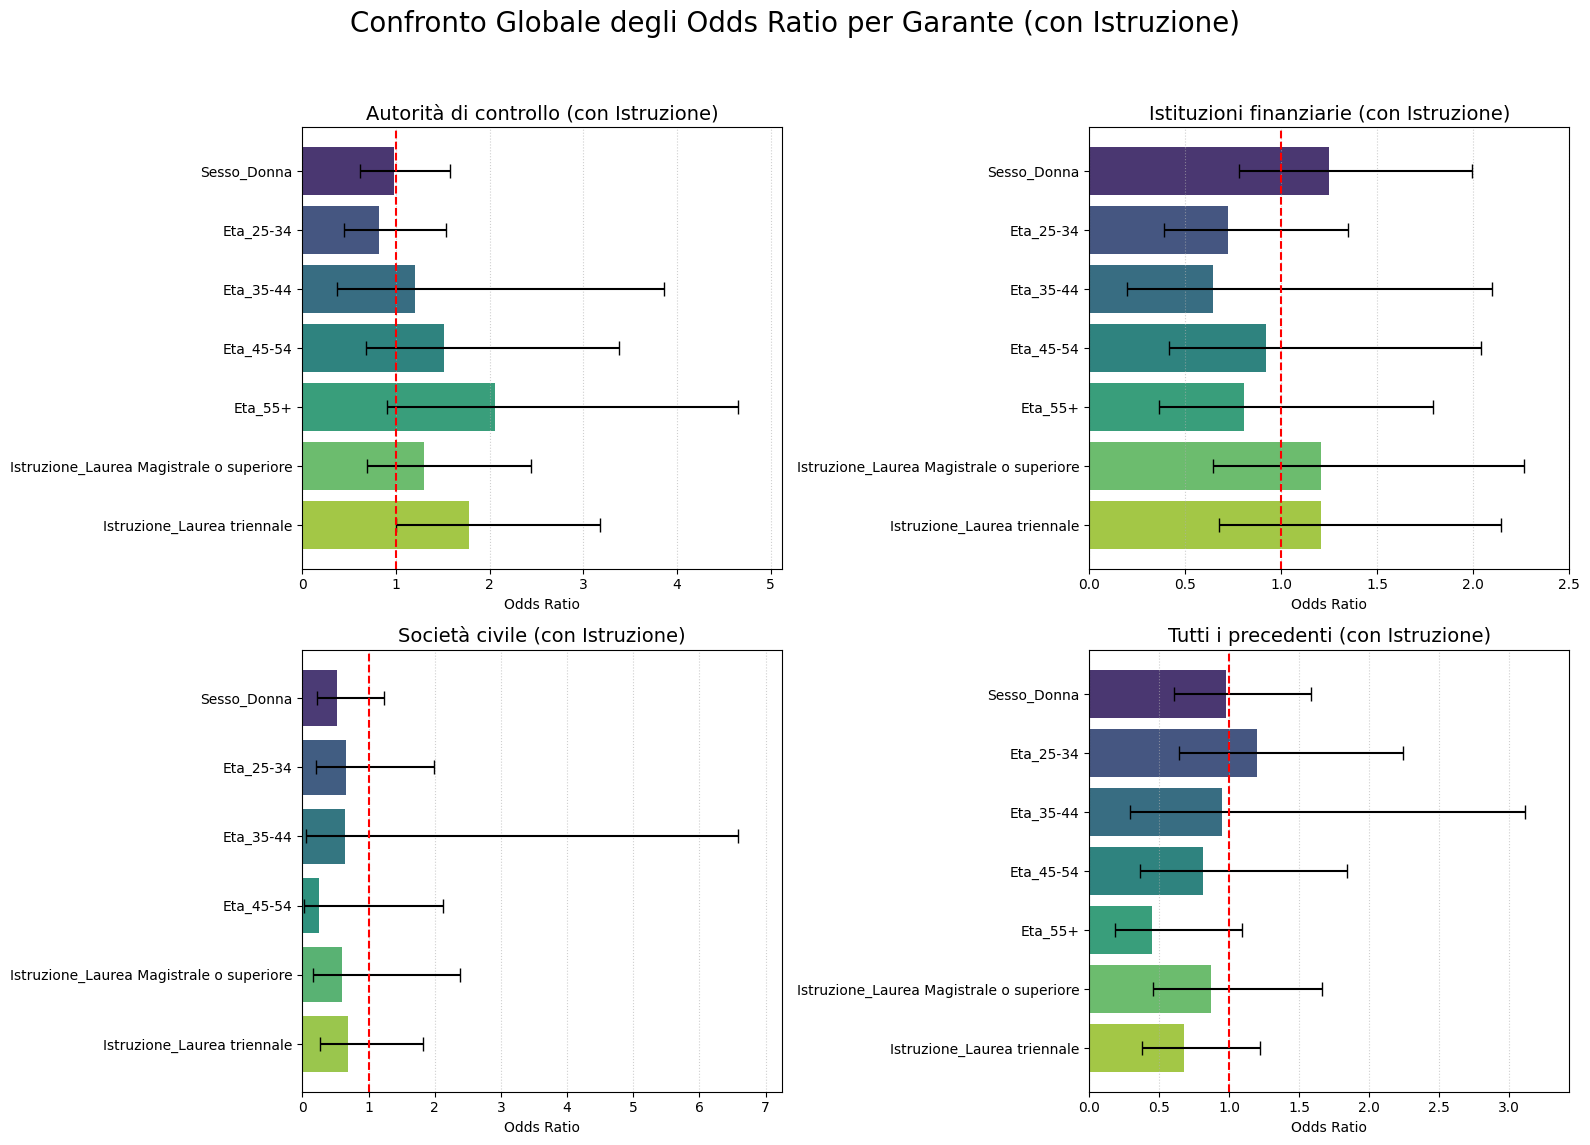

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

all_or_dfs_new = [or_results1_new, or_results2_new, or_results3_new, or_results4_new]
titles_new = [
    'Autorità di controllo (con Istruzione)',
    'Istituzioni finanziarie (con Istruzione)',
    'Società civile (con Istruzione)',
    'Tutti i precedenti (con Istruzione)'
]

for i, (df, title) in enumerate(zip(all_or_dfs_new, titles_new)):
    df_plot = df.drop('const')

    # Handle 'Eta_55+' for Società civile due to 'inf' in CI 95% High
    if title == 'Società civile (con Istruzione)':
        df_plot = df_plot.drop('Eta_55+', errors='ignore')

    # Calculate error bars for current plot, ensuring 'inf' values are handled
    err_low = df_plot['Odds Ratio'] - df_plot['CI 95% Low']
    err_high = df_plot['CI 95% High'] - df_plot['Odds Ratio']

    # Replace 'inf' in error bars with NaN for plotting purposes
    err_high = err_high.replace([np.inf, -np.inf], np.nan)
    # Combine into a 2-row array for errorbar function
    err = np.array([err_low, err_high])

    sns.barplot(ax=axes[i], x='Odds Ratio', y=df_plot.index, data=df_plot, palette='viridis', hue=df_plot.index, legend=False)
    axes[i].errorbar(x=df_plot['Odds Ratio'], y=range(len(df_plot)), xerr=err, fmt='none', c='black', capsize=5)

    axes[i].axvline(1, color='red', linestyle='--', linewidth=1.5)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlim(0, max(2.5, df_plot['CI 95% High'].max() * 1.1)) # Adjust xlim dynamically
    axes[i].grid(axis='x', linestyle=':', alpha=0.6)
    axes[i].set_ylabel('') # Remove y-label for cleaner look in grid

plt.suptitle('Confronto Globale degli Odds Ratio per Garante (con Istruzione)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Confronto_OR_Grid_new.png')
plt.show()

Il confronto tra i nuovi modelli, che includono ora la variabile 'istruzione_grouped', rivela alcuni cambiamenti rispetto ai modelli originali.

**Modello 'Autorità di controllo'**: L'introduzione della variabile `istruzione_grouped` ha portato la categoria 'Laurea triennale' a mostrare una propensione quasi significativa ($OR=1.78, p=0.052$) a scegliere le autorità di controllo rispetto alla baseline (scuola secondaria o inferiore). La fascia d'età 55+ rimane un predittore forte e positivo ($OR=2.05, p=0.085$), pur con una significatività leggermente ridotta, ma ancora sulla soglia.

**Modello 'Istituzioni finanziarie'**: Anche in questo modello, nessun predittore si attesta su una significatività statistica forte. La variabile 'Sesso_Donna' mostra ancora una tendenza positiva ($OR=1.25$), mentre le fasce d'età più adulte continuano a mostrare una propensione inferiore rispetto alla baseline (18-24 anni). L'istruzione non introduce variazioni significative in questa scelta.

**Modello 'Società civile'**: Questo modello continua a mostrare la quasi-separazione per 'Eta_55+', confermando che i senior non scelgono questa opzione. Le categorie di istruzione ('Laurea Magistrale o superiore' e 'Laurea triennale') mostrano coefficienti negativi, suggerendo una minore propensione per la Società Civile all'aumentare del livello di istruzione, anche se senza forte significatività. Il genere femminile continua ad avere una propensione inferiore ($OR=0.52$).

**Modello 'Tutti i precedenti'**: Anche in questo caso, l'introduzione dell'istruzione non ha modificato sostanzialmente il quadro. La fascia d'età 55+ mantiene una propensione significativamente inferiore ($OR=0.45, p=0.077$) rispetto ai giovani a scegliere questa opzione. Le categorie di istruzione mostrano Odds Ratio inferiori a 1, indicando una minore probabilità di scegliere 'Tutti i precedenti' per chi ha un livello di istruzione più elevato rispetto alla baseline, ma senza raggiungere la significatività statistica.

**Reasoning**:
Now that the Odds Ratios have been summarized, the next step is to generate a grouped plot of the ROC curves for the new models. This will allow for a visual comparison of their predictive capabilities, including the impact of the newly added education variable.



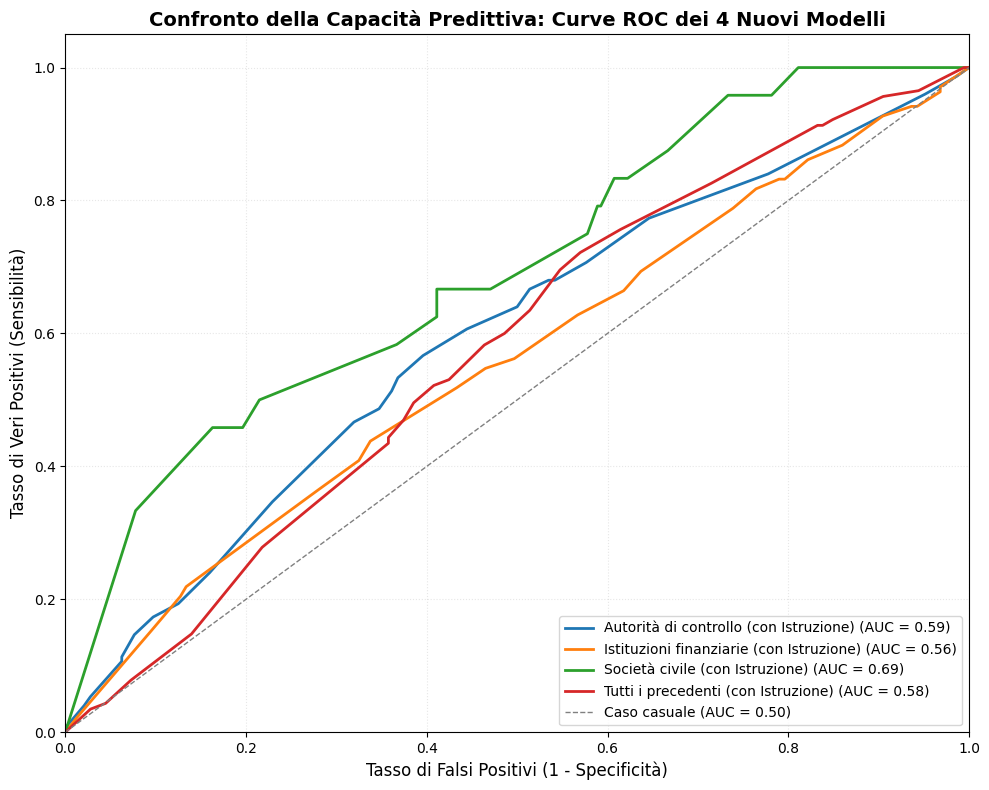

In [64]:
plt.figure(figsize=(10, 8))

modelli_new = [
    (model1_new, y1_new, 'Autorità di controllo (con Istruzione)', '#1f77b4'),
    (model2_new, y2_new, 'Istituzioni finanziarie (con Istruzione)', '#ff7f0e'),
    (model3_new, y3_new, 'Società civile (con Istruzione)', '#2ca02c'),
    (model4_new, y4_new, 'Tutti i precedenti (con Istruzione)', '#d62728')
]

for mod, y_true, label, color in modelli_new:
    y_scores = mod.predict(X_new.astype(float))
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Caso casuale (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasso di Falsi Positivi (1 - Specificità)', fontsize=12)
plt.ylabel('Tasso di Veri Positivi (Sensibilità)', fontsize=12)
plt.title('Confronto della Capacità Predittiva: Curve ROC dei 4 Nuovi Modelli', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()

plt.savefig('confronto_finale_ROC_new.png', dpi=300)
plt.show()

Il confronto tra le curve ROC dei nuovi modelli offre ulteriori spunti sulla capacità predittiva. Come nei modelli originali, il genere e l'età rimangono i principali fattori distintivi, mentre l'istruzione introduce alcune sfumature, ma senza stravolgere il quadro generale.

**Modello 'Società civile' (AUC 0.69)**: Mantiene il più alto valore di AUC, quasi invariato rispetto al modello precedente. Questo conferma che l'assenza di preferenze nella fascia over 55 e una generale minore propensione all'aumentare dell'istruzione, consentono al modello di discriminare efficacemente chi non sceglierà mai questa opzione. L'istruzione, sebbene con p-value non significativi, rafforza la tendenza negativa.

**Modello 'Autorità di controllo' (AUC 0.59)**: L'AUC è leggermente migliorato (da 0.58 a 0.59), indicando un marginale aumento della capacità predittiva. Questo potrebbe essere attribuito alla quasi-significatività della 'Laurea triennale' che mostra una maggiore propensione per questo garante. Tuttavia, il modello rimane relativamente vicino alla linea del caso, suggerendo che le preferenze per le autorità di controllo siano ancora influenzate da fattori non inclusi nel modello.

**Modello 'Tutti i precedenti' (AUC 0.58)**: L'AUC è rimasto pressoché invariato (da 0.56 a 0.58), indicando che l'introduzione dell'istruzione non ha migliorato significativamente la capacità predittiva del modello. La polarizzazione generazionale (con i 55+ che mostrano minore propensione) continua ad essere il principale driver predittivo.

**Modello 'Istituzioni finanziarie' (AUC 0.56)**: L'AUC è rimasto stabile (0.55), confermando che questo modello ha la minor capacità predittiva. Questo suggerisce che la fiducia nelle istituzioni finanziarie come garanti della trasparenza sia una preferenza molto diffusa e poco spiegabile dalle variabili demografiche e di istruzione incluse nel modello. Le nuove variabili di istruzione non hanno apportato miglioramenti significativi alla sua capacità discriminatoria.

In sintesi, l'introduzione della variabile 'istruzione_grouped' non ha modificato radicalmente le capacità predittive complessive dei modelli, se non per un leggero miglioramento nel modello 'Autorità di controllo'. Il genere continua a non essere un predittore significativo in quasi tutti i modelli, mentre l'età rimane la variabile più influente, soprattutto per la scelta di 'Società civile' e la propensione degli over 55 verso le 'Autorità di controllo' o la loro avversione per l'opzione 'Tutti i precedenti'. Le curve ROC confermano che, ad eccezione del modello 'Società civile' (che beneficia di una chiara quasi-separazione), gli altri modelli faticano a identificare pattern predittivi robusti basati solo su età, genere e livello di istruzione.

## Summary:

### Q&A
The inclusion of the `istruzione_grouped` variable introduced some nuances but did not fundamentally alter the overall predictive power or interpretation of the models, with age remaining the most influential demographic factor.

*   **Odds Ratio and Significance:**
    *   **Autorità di controllo**: The 'Laurea triennale' category showed a nearly significant propensity (Odds Ratio = 1.78, p = 0.052) for choosing control authorities. The `Eta_55+` group remained a strong positive predictor (Odds Ratio = 2.05, p = 0.085), though with slightly reduced significance.
    *   **Istituzioni finanziarie**: No predictor achieved strong statistical significance. 'Sesso_Donna' showed a positive trend (Odds Ratio = 1.25), while older age groups continued to show a lower propensity. Education did not introduce significant variations.
    *   **Società civile**: The model continued to exhibit quasi-separation for 'Eta_55+', indicating that seniors rarely choose this option. Higher education levels ('Laurea Magistrale o superiore' and 'Laurea triennale') suggested a lower propensity for Civil Society, but without strong significance. Female gender continued to show a lower propensity (Odds Ratio = 0.52).
    *   **Tutti i precedenti**: The `Eta_55+` group maintained a significantly lower propensity (Odds Ratio = 0.45, p = 0.077) compared to younger individuals. Higher education categories showed Odds Ratios below 1, implying a lower likelihood of choosing 'Tutti i precedenti', but without statistical significance.

*   **AUC Scores:**
    *   **Società civile**: Maintained the highest AUC at 0.69, nearly unchanged, indicating strong discriminatory power, largely due to the clear patterns related to age.
    *   **Autorità di controllo**: Showed a marginal improvement in AUC from 0.58 to 0.59.
    *   **Tutti i precedenti**: The AUC remained largely stable, improving from 0.56 to 0.58.
    *   **Istituzioni finanziarie**: The AUC remained stable at 0.56 (from 0.55), indicating the lowest predictive capacity among the models.

### Data Analysis Key Findings
*   The `istruzione_grouped` variable did not substantially change the overall predictive capabilities of the models, except for a slight improvement in the 'Autorità di controllo' model (AUC increased from 0.58 to 0.59).
*   The 'Laurea triennale' education level showed a quasi-significant positive association with choosing 'Autorità di controllo' (Odds Ratio = 1.78, p = 0.052).
*   The 'Società civile' model continued to demonstrate the highest predictive power (AUC = 0.69), primarily driven by the strong negative association with the 'Eta_55+' group, which experienced quasi-separation in the model.
*   Gender (`Sesso_Donna`) remained largely non-significant across most models, while age (`eta_grouped`) continued to be the most influential demographic predictor, particularly for 'Società civile' and 'Tutti i precedenti'.
*   The 'Istituzioni finanziarie' model remained the least predictive (AUC = 0.56), suggesting that preferences for this guarantor are not well-explained by the included demographic and education variables.

### Insights or Next Steps
*   Consider exploring interaction terms between `istruzione_grouped` and `eta_grouped` to uncover more nuanced relationships, as the individual impact of education was limited.
*   Investigate additional socio-economic or psychological variables (e.g., income, political affiliation, trust in institutions) that might better explain preferences, especially for 'Istituzioni finanziarie' and 'Tutti i precedenti', given the low predictive power of current models for these outcomes.
